In [15]:
import numpy as np
import cv2
import os
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [16]:
# Paths for preprocessed data
PREPROCESSED_TRAIN_DIR = "../data/preprocessed_data/traffic/trainNew/"
PREPROCESSED_TEST_DIR = "../data/preprocessed_data/traffic/testNew"

image_size = (100, 100)

# Load preprocessed training data
print("Loading preprocessed training data...")
X_train = []
Y_train = []

for class_name in os.listdir(PREPROCESSED_TRAIN_DIR):
    class_dir = os.path.join(PREPROCESSED_TRAIN_DIR, class_name)
    label = int(class_name)  # As directories are named by class numbers
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Images are already grayscale due to preprocessing
        if img is not None:
            X_train.append(img)
            Y_train.append(label)

X_train = np.array(X_train).reshape(-1, *image_size, 1)
Y_train = np.array(Y_train)
print(f"Loaded {X_train.shape[0]} training images.")

Loading preprocessed training data...
Loaded 6000 training images.


In [17]:
# load preprocessed test data
print("Loading preprocessed test data...")
X_test = []

for img_name in os.listdir(PREPROCESSED_TEST_DIR):
    img_path = os.path.join(PREPROCESSED_TEST_DIR, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
    if img is not None:
        X_test.append(img)

X_test = np.array(X_test).reshape(-1, *image_size, 1)
print(f"Loaded {X_test.shape[0]} test images.")

Loading preprocessed test data...
Loaded 1896 test images.


In [18]:
# Flatten the images
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Standardize the data (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

In [19]:
# Apply PCA
print("Applying PCA...")
n_components = 2  
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original shape: {X_train_flattened.shape}")
print(f"PCA-reduced shape: {X_train_pca.shape}")

Applying PCA...
Original shape: (6000, 10000)
PCA-reduced shape: (6000, 2)


Evaluating KMeans Clusters: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.89it/s]


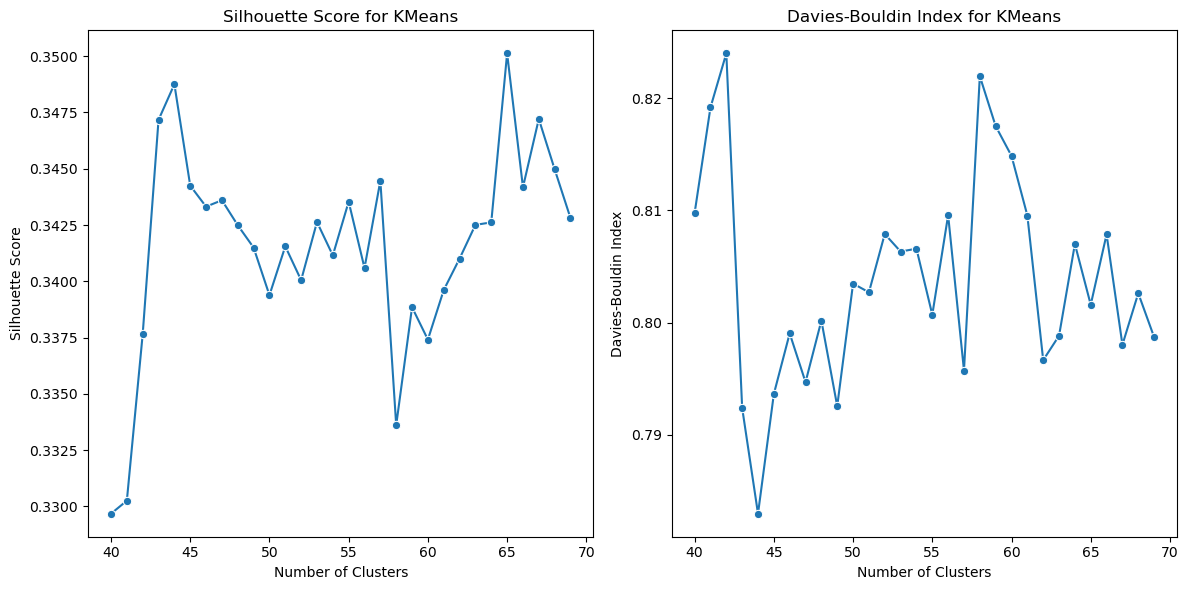

Best number of clusters based on Silhouette Score: 65 (Score: 0.3501)
Best number of clusters based on Davies-Bouldin Index: 44 (Score: 0.7830)


In [24]:
# Implementing Silhouette Score and Davies-Bouldin Index 
def evaluate_kmeans(X_pca, cluster_range):
    silhouette_scores = []
    db_scores = []
    results = []

    for k in tqdm(cluster_range, desc="Evaluating KMeans Clusters"):
        kmeans = KMeans(n_clusters=k, n_init=1, init='random', random_state=42)
        labels = kmeans.fit_predict(X_pca)
        
        # Computing Silhouette Score and Davies-Bouldin Index
        silhouette = silhouette_score(X_pca, labels) if k > 1 else -1  # Silhouette not valid for k=1
        db_index = davies_bouldin_score(X_pca, labels) if k > 1 else float('inf')
        
        silhouette_scores.append(silhouette)
        db_scores.append(db_index)
        
        results.append((k, silhouette, db_index))

    return results, silhouette_scores, db_scores

# Defining cluster range and compute metrics
cluster_range = range(40, 70)  # Adjust the range as needed
results, silhouette_scores, db_scores = evaluate_kmeans(X_train_pca, cluster_range)

# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame(results, columns=['Clusters', 'Silhouette Score', 'Davies-Bouldin Index'])

# Step 3: Plot the metrics
plt.figure(figsize=(12, 6))

# Plot Silhouette Score
plt.subplot(1, 2, 1)
sns.lineplot(data=results_df, x='Clusters', y='Silhouette Score', marker='o')
plt.title('Silhouette Score for KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

# Plot Davies-Bouldin Index
plt.subplot(1, 2, 2)
sns.lineplot(data=results_df, x='Clusters', y='Davies-Bouldin Index', marker='o')
plt.title('Davies-Bouldin Index for KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

# Step 4: Print the best results
best_silhouette_index = results_df['Silhouette Score'].idxmax()
best_silhouette_clusters = results_df.loc[best_silhouette_index, 'Clusters']
best_silhouette_score = results_df.loc[best_silhouette_index, 'Silhouette Score']

best_db_index = results_df['Davies-Bouldin Index'].idxmin()
best_db_clusters = results_df.loc[best_db_index, 'Clusters']
best_db_score = results_df.loc[best_db_index, 'Davies-Bouldin Index']

print(f"Best number of clusters based on Silhouette Score: {best_silhouette_clusters} (Score: {best_silhouette_score:.4f})")
print(f"Best number of clusters based on Davies-Bouldin Index: {best_db_clusters} (Score: {best_db_score:.4f})")


Applying Elbow Method...


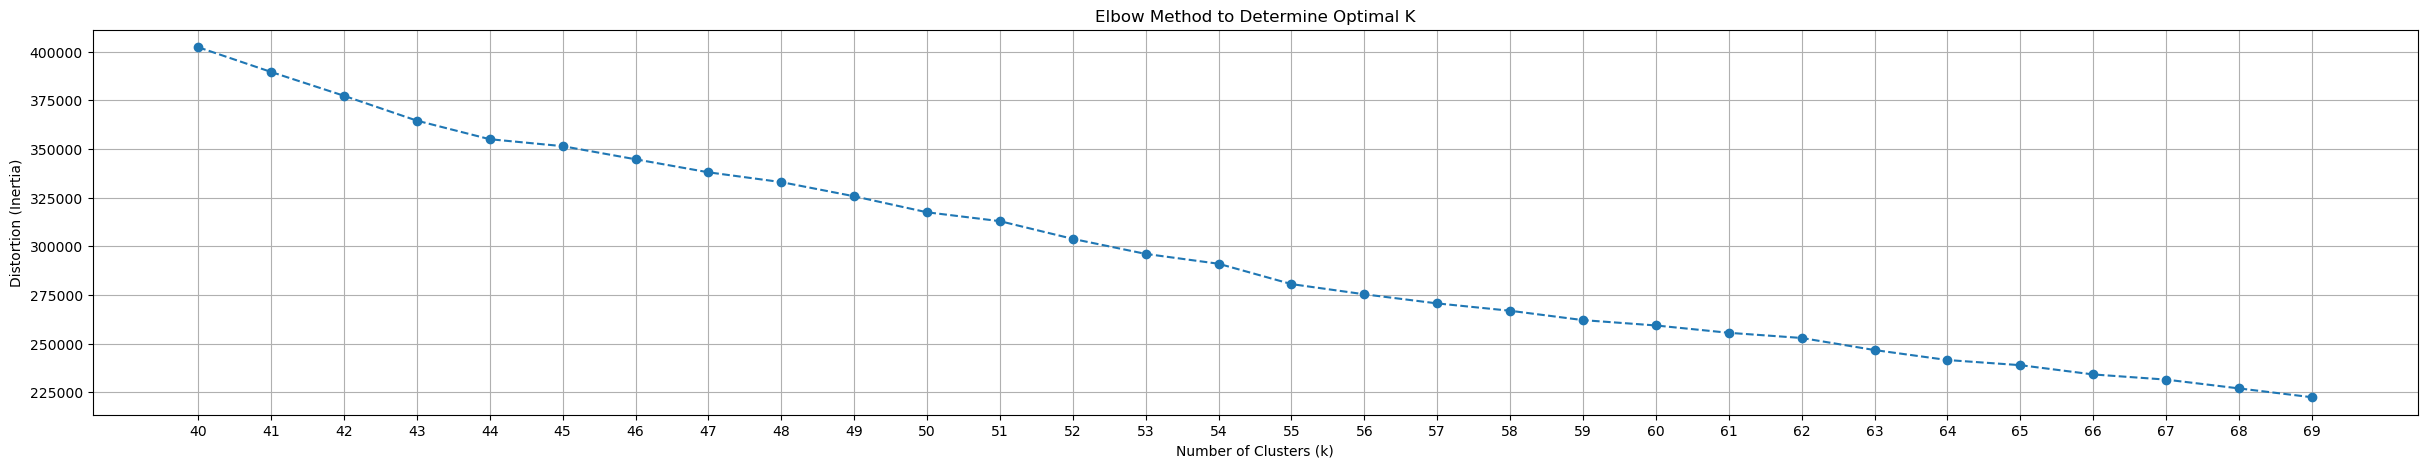

In [21]:
# Elbow Method - To determine optimal number of clusters
print("Applying Elbow Method...")
distortions = []
K = range(40, 70)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca)
    distortions.append(kmeans.inertia_)  # Inertia measures within-cluster sum of squares

# Plot the elbow curve
plt.figure(figsize=(30, 5))
plt.plot(K, distortions, marker='o', linestyle='--')
plt.title('Elbow Method to Determine Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion (Inertia)')
plt.xticks(K)
plt.grid()
plt.show()

We used the range of 40-70 to test the 'k' values as our dataset has a large number of classes. 

Optimal number of clusters based on the elbow method and Davies-Bouldin Index: 44


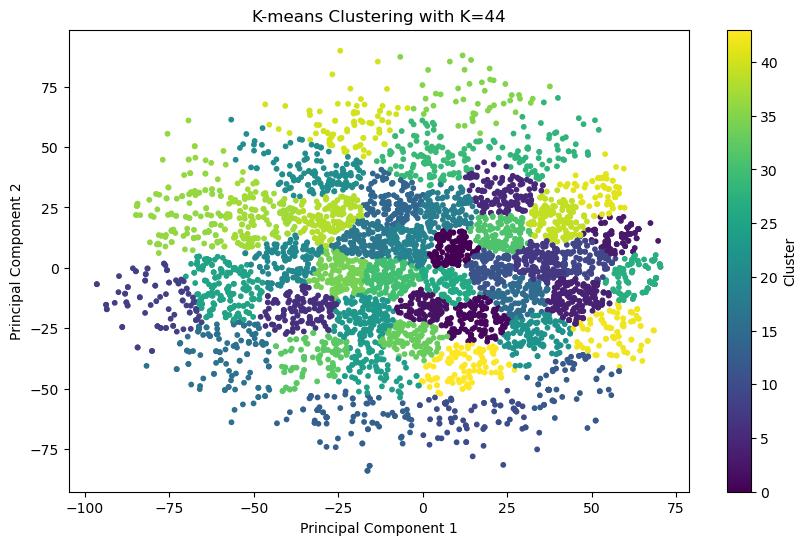

In [33]:
# 1st k-value: k=44
optimal_k = 44 
print(f"Optimal number of clusters based on the elbow method and Davies-Bouldin Index: {optimal_k}")

#n_init=1 and init='random' according to lab
kmeans = KMeans(n_clusters=optimal_k, n_init=1, init='random')
kmeans.fit(X_train_pca)

# Cluster assignments
train_clusters = kmeans.labels_

plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_clusters, cmap='viridis', s=10)
plt.title(f'K-means Clustering with K={optimal_k}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [34]:
kmeans_analysis = pd.DataFrame({
    'original_label': Y_train,  # True labels
    'cluster_label': train_clusters  # Cluster assignments
})

# Map cluster labels to original labels (majority voting)
cluster_mapping = kmeans_analysis.groupby('cluster_label')['original_label'].agg(lambda x: x.value_counts().index[0])
mapped_labels = train_clusters.copy()
for cluster_id, label in cluster_mapping.items():
    mapped_labels[train_clusters == cluster_id] = label

# Metrics for multiclass
true_labels = Y_train  
predicted_labels = mapped_labels 

# `zero_division=0` to suppress warnings for undefined cases
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

print("Accuracy:", accuracy)
print("Precision (Weighted):", precision)
print("Recall (Weighted):", recall)
print("F1 Score (Weighted):", f1)

Accuracy: 0.141
Precision (Weighted): 0.081772331424197
Recall (Weighted): 0.141
F1 Score (Weighted): 0.09138803738063864


Optimal number of clusters based on the elbow method and Silhouette Score: 65


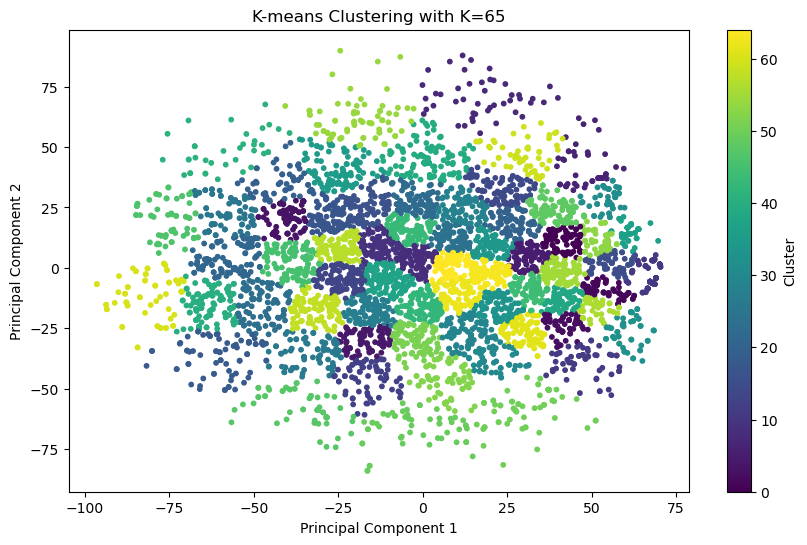

In [35]:
# 2nd k-value: k=65
optimal_k = 65
print(f"Optimal number of clusters based on the elbow method and Silhouette Score: {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, n_init=1, init='random')
kmeans.fit(X_train_pca)

# Cluster assignments
train_clusters = kmeans.labels_

plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_clusters, cmap='viridis', s=10)
plt.title(f'K-means Clustering with K={optimal_k}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [36]:
# DataFrame to analyze clusters
kmeans_analysis = pd.DataFrame({
    'original_label': Y_train,  # True labels
    'cluster_label': train_clusters  # Cluster assignments
})

# Map cluster labels to original labels (majority voting)
cluster_mapping = kmeans_analysis.groupby('cluster_label')['original_label'].agg(lambda x: x.value_counts().index[0])
mapped_labels = train_clusters.copy()
for cluster_id, label in cluster_mapping.items():
    mapped_labels[train_clusters == cluster_id] = label

# Metrics for multiclass
true_labels = Y_train  
predicted_labels = mapped_labels  

# `zero_division=0` to suppress warnings for undefined cases
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

print("Accuracy:", accuracy)
print("Precision (Weighted):", precision)
print("Recall (Weighted):", recall)
print("F1 Score (Weighted):", f1)

Accuracy: 0.16183333333333333
Precision (Weighted): 0.10246593808625919
Recall (Weighted): 0.16183333333333333
F1 Score (Weighted): 0.11783270623857976


K-Means is not optimal for our dataset due to the low accuracy of the 65 and 44 clusters shown above. However, 65 clusters has a better accuracy than 44 clusters.

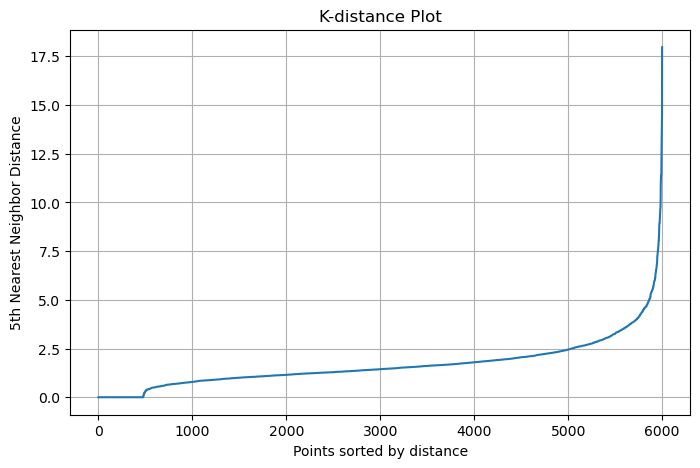

In [13]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_train_pca)
distances, indices = neighbors_fit.kneighbors(X_train_pca)

# Sort distances and plot
distances = np.sort(distances[:, -1])
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('K-distance Plot')
plt.xlabel('Points sorted by distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.grid()
plt.show()

In [14]:
# DBSCAN
eps = 2.5  # Maximum distance between two points in the same cluster
min_samples = 5  # Minimum number of points to form a cluster
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X_train_pca)

Number of clusters: 76
Number of noise points: 612


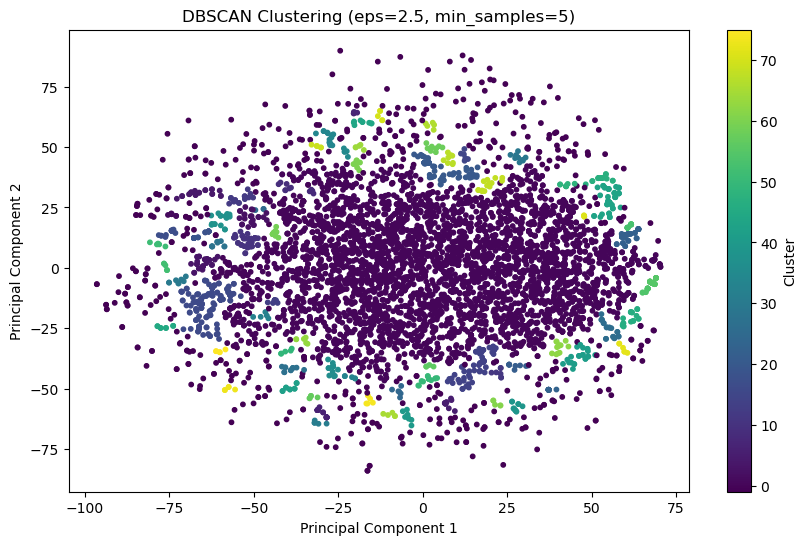

In [37]:
# Evaluating results
num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
num_noise_points = list(dbscan_labels).count(-1)
print(f"Number of clusters: {num_clusters}")
print(f"Number of noise points: {num_noise_points}")

plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=dbscan_labels, cmap='viridis', s=10)
plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [38]:
# Exclude noise points (-1) for evaluation
mask = dbscan_labels != -1  # Filter out noise points
filtered_labels = dbscan_labels[mask]
filtered_true_labels = Y_train[mask]

# Map cluster labels to original labels (majority voting)
dbscan_analysis = pd.DataFrame({
    'original_label': filtered_true_labels,
    'cluster_label': filtered_labels
})

# Map each cluster label to the most frequent original label in the cluster
cluster_mapping = dbscan_analysis.groupby('cluster_label')['original_label'].agg(lambda x: x.value_counts().index[0])
mapped_labels = filtered_labels.copy()
for cluster_id, label in cluster_mapping.items():
    mapped_labels[filtered_labels == cluster_id] = label

# Metrics for multiclass (excluding noise points)
true_labels = filtered_true_labels
predicted_labels = mapped_labels

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

print("Accuracy (excluding noise):", accuracy)
print("Precision (Weighted, excluding noise):", precision)
print("Recall (Weighted, excluding noise):", recall)
print("F1 Score (Weighted, excluding noise):", f1)

Accuracy (excluding noise): 0.10616184112843356
Precision (Weighted, excluding noise): 0.30066918794869885
Recall (Weighted, excluding noise): 0.10616184112843356
F1 Score (Weighted, excluding noise): 0.10575057624564946


DBSCAN outperforms K-means in terms of Precision for this dataset. However, K-means with k=65 has the highest accuracy out of k=44 and DBSCAN. Overall, all three of these clustering models perform very poorly with our image dataset due to lack of meaningful feature representation, and the inability of raw pixel values to capture semantic similarities between images.